This notebook plays around with scikit learn classifiers to do some basic sentiment analysis using the IMDB movie review dataset. It turns out that SVM linear classifiers perform very well on a tri-gram model (~8% test error)

In [1]:
import numpy as np
from sklearn import svm
from os import listdir
from os.path import isfile, join
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
import time
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer_noidf = TfidfTransformer(use_idf=False)
max_abs_scaler = preprocessing.MaxAbsScaler()

In [2]:
parentpath='/home/orlandom/Documents/UdeM/A2017/IFT6390/Project/'

#Load files in the IMDB train set
mypath=parentpath + 'aclImdb/train/pos/'
files_pos_train = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]
mypath=parentpath + 'aclImdb/train/neg/'
files_neg_train = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]

#Load files in the IMDB test set
mypath=parentpath + 'aclImdb/test/pos/'
files_pos_test = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]
mypath=parentpath + 'aclImdb/test/neg/'
files_neg_test = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]

files = files_pos_train + files_pos_test + files_neg_train + files_neg_test

vocab_file = open(parentpath + 'aclImdb/imdb.vocab', "r")
vocab = vocab_file.read().splitlines()

### Load data and do some transformation

In [3]:
#Unigram
cv_wo_stop_w = CountVectorizer(input='filename', stop_words='english', 
                                   min_df=3, max_df=0.95, dtype='int32')
corpus_wo_stop_w = cv_wo_stop_w.fit_transform(files)

cv_w_stop_w = CountVectorizer(input='filename', min_df=3, max_df=0.95, dtype='int32', vocabulary=vocab)
corpus_w_stop_w = cv_w_stop_w.fit_transform(files)

#Bigram
cv_wo_stop_w_bi = CountVectorizer(input='filename', min_df=3, max_df=0.95, dtype='int32', ngram_range=(1, 2),
                                  stop_words='english') #vocabulary=vocab,
corpus_wo_stop_w_bi = cv_wo_stop_w_bi.fit_transform(files)

cv_w_stop_w_bi = CountVectorizer(input='filename', min_df=3, max_df=0.95, dtype='int32', 
                                 ngram_range=(1, 2)) #vocabulary=vocab,
corpus_w_stop_w_bi = cv_w_stop_w_bi.fit_transform(files)

#Trigram
cv_wo_stop_w_tri = CountVectorizer(input='filename', min_df=3, max_df=0.95, dtype='int32', ngram_range=(1, 3),
                                  stop_words='english') #vocabulary=vocab,
corpus_wo_stop_w_tri = cv_wo_stop_w_tri.fit_transform(files)

cv_w_stop_w_tri = CountVectorizer(input='filename', min_df=3, max_df=0.95, dtype='int32', 
                                 ngram_range=(1, 3)) #vocabulary=vocab,
corpus_w_stop_w_tri = cv_w_stop_w_tri.fit_transform(files)

In [5]:
def analyze_corpus_data(corpus, count_vectorizer):
    size_vocab = len(count_vectorizer.vocabulary_)
    size_docs = np.zeros(corpus.shape[0])

    for i in range(corpus.indptr.shape[0]-1):
        size_docs[i] = corpus.indptr[i+1] - corpus.indptr[i]
        
    print "Vocabulary size:", size_vocab
    print "Minimum size of doc is {} and maximum size is {}".format(int(min(size_docs)), int(max(size_docs)))
    print "Mean size is {} and variance is {}".format(np.round(size_docs.mean(),2), np.round(size_docs.var(),2))

print "Removing stop words - trigram"
analyze_corpus_data(corpus_wo_stop_w_tri, cv_wo_stop_w_tri)
print "Leaving stop words - trigram"
analyze_corpus_data(corpus_w_stop_w_tri, cv_w_stop_w_tri)
print "Removing stop words - bigram"
analyze_corpus_data(corpus_wo_stop_w_bi, cv_wo_stop_w_bi)
print "Leaving stop words - bigram"
analyze_corpus_data(corpus_w_stop_w_bi, cv_w_stop_w_bi)
print "Removing stop words - unigram"
analyze_corpus_data(corpus_wo_stop_w, cv_wo_stop_w)
print "Leaving stop words - unigram"
analyze_corpus_data(corpus_w_stop_w, cv_w_stop_w)

Removing stop words - trigram
Vocabulary size: 366483
Minimum size of doc is 3 and maximum size is 1040
Mean size is 142.21 and variance is 8696.3
Leaving stop words - trigram
Vocabulary size: 905884
Minimum size of doc is 8 and maximum size is 3026
Mean size is 386.44 and variance is 61867.72
Removing stop words - bigram
Vocabulary size: 308910
Minimum size of doc is 3 and maximum size is 1001
Mean size is 133.68 and variance is 7720.09
Leaving stop words - bigram
Vocabulary size: 455551
Minimum size of doc is 8 and maximum size is 2151
Mean size is 298.88 and variance is 36446.52
Removing stop words - unigram
Vocabulary size: 47624
Minimum size of doc is 3 and maximum size is 773
Mean size is 87.37 and variance is 3573.64
Leaving stop words - unigram
Vocabulary size: 89527
Minimum size of doc is 4 and maximum size is 940
Mean size is 134.63 and variance is 6129.57


In [6]:
def split_data(corpus, num_train=40000, num_valid=5000, num_test=5000):

    #Create train, valid and test data
    doc_index = np.arange(corpus.shape[0])
    target_pos = np.ones(corpus.shape[0]/2).astype(int) #first 25000 docs have target 1=positive
    target_neg = np.zeros(corpus.shape[0]/2).astype(int) #next 25000 docs have target 0=negative
    target = np.concatenate((target_pos, target_neg), axis=0) #now we have data and target values

    #shuffle all of the data and target
    doc_index, corpus, target = shuffle(doc_index, corpus, target, random_state=0)

    train_data = corpus[:num_train]
    train_targets = target[:num_train]
    valid_data = corpus[num_train:num_train+num_valid]
    valid_targets = target[num_train:num_train+num_valid]
    test_data = corpus[num_train+num_valid:]
    test_targets = target[num_train+num_valid:]

    return train_data, train_targets, valid_data, valid_targets, test_data, test_targets

In [7]:
def eval_clf(clf, data):
    
    train_data = data[0]
    train_targets = data[1]
    valid_data = data[2]
    valid_targets = data[3]
    
    time0 = time.time()

    clf.fit(train_data, train_targets) 
    predictions_train = clf.predict(train_data)
    error_train = 1 - (predictions_train == train_targets).mean()
    predictions_valid = clf.predict(valid_data)
    error_valid = 1 - (predictions_valid == valid_targets).mean()

    time1 = time.time()

    print "It took {} seconds".format(time1-time0)
    print "Training error: ", error_train*100
    print "Validation error: ", error_valid*100
    
    return error_train, error_valid

In [8]:
data_corpus=[corpus_w_stop_w_tri, corpus_wo_stop_w_tri, corpus_w_stop_w_bi, 
             corpus_wo_stop_w_bi, corpus_w_stop_w, corpus_wo_stop_w]

#No transformation
data_raw = []
data_tf = []
data_tfidf = []
data_scaled = []

for corpus in data_corpus:
    data_raw.append(split_data(corpus))
    data_tf.append(split_data(tfidf_transformer_noidf.fit_transform(corpus)))
    data_tfidf.append(split_data(tfidf_transformer.fit_transform(corpus)))
    data_scaled.append(split_data(max_abs_scaler.fit_transform(corpus)))


In [ ]:
linearSVM = svm.LinearSVC()

headers = ["Trigram: Run data set with stop words-------------------",
           "Trigram: Run data set without stop words-------------------",
           "Bigram: Run data set with stop words-------------------",
           "Bigram: Run data set without stop words-------------------",
           "Unigram: Run data set with stop words-------------------",
           "Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_raw):
    print header
    eval_clf(linearSVM, corpus)

### Run data after doing only TF transformation

In [ ]:
headers = ["TF Trigram: Run data set with stop words-------------------",
           "TF Trigram: Run data set without stop words-------------------",
           "TF Bigram: Run data set with stop words-------------------",
           "TF Bigram: Run data set with stop words-------------------",
           "TF Unigram: Run data set with stop words-------------------",
           "TF Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_tf):
    print header
    eval_clf(linearSVM, corpus)

### Run previous data after doing TF-IDF transformation

In [ ]:
headers = ["TF-IDF Trigram: Run data set with stop words-------------------",
           "TF-IDF Trigram: Run data set without stop words-------------------",
           "TF-IDF Bigram: Run data set with stop words-------------------",
           "TF-IDF Bigram: Run data set without stop words-------------------",
           "TF-IDF Unigram: Run data set with stop words-------------------",
           "TF-IDF Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_tfidf):
    print header
    eval_clf(linearSVM, corpus)

### Run previous data after scaling

In [ ]:
headers = ["Scaled Trigram: Run data set with stop words-------------------",
           "Scaled Trigram: Run data set without stop words-------------------",
           "Scaled Bigram: Run data set with stop words-------------------",
           "Scaled Bigram: Run data set without stop words-------------------",
           "Scaled Unigram: Run data set with stop words-------------------",
           "Scaled Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_scaled):
    print header
    eval_clf(linearSVM, corpus)

In [ ]:
# Play with SVM parameters for bigram and trigram with stop words

losses = ['hinge', 'squared_hinge']
penalties = ['l2']
tols = [1e-2, 1e-3, 1e-4, 1e-5]
Cs = [1, 10, 100, 1000, 10000]

for loss in losses:
    for penalty in penalties:
        for tol in tols:
            for C in Cs:
                linearSVM = svm.LinearSVC(C=C, loss=loss, penalty=penalty, tol=tol)
                print "Loss=", loss, " Penalty=", penalty, " Tol=", tol, " C=", C
                print "Trigram"
                eval_clf(linearSVM, data_tfidf[0])
                print "Bigram"
                eval_clf(linearSVM, data_tfidf[2])


In [ ]:
losses = ['squared_hinge']
penalties = ['l2']
tols = [1e-2, 1e-3]
Cs = [0.01, 0.1, 0.5]


print "Trigram----------------"
for loss in losses:
    for penalty in penalties:
        for tol in tols:
            for C in Cs:
                linearSVM = svm.LinearSVC(C=C, loss=loss, penalty=penalty, tol=tol)
                print "Loss=", loss, " Penalty=", penalty, " Tol=", tol, " C=", C                
                eval_clf(linearSVM, data_tfidf[0])
                
                
print "Bigram-----------------"                
for loss in losses:
    for penalty in penalties:
        for tol in tols:
            for C in Cs:
                linearSVM = svm.LinearSVC(C=C, loss=loss, penalty=penalty, tol=tol)
                print "Loss=", loss, " Penalty=", penalty, " Tol=", tol, " C=", C
                
                eval_clf(linearSVM, data_tfidf[2])

In [ ]:
losses = ['squared_hinge']
penalties = ['l2']
tols = [1e-3]
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

for loss in losses:
    for penalty in penalties:
        for tol in tols:
            for C in Cs:
                linearSVM = svm.LinearSVC(C=C, loss=loss, penalty=penalty, tol=tol)
                print "Loss=", loss, " Penalty=", penalty, " Tol=", tol, " C=", C
                print "Trigram"
                eval_clf(linearSVM, data_tfidf[0])
                print "Bigram"
                eval_clf(linearSVM, data_tfidf[2])

In [ ]:
loss = 'squared_hinge'
penalty = 'l2'
tol = 1e-3
Cs = np.arange(0.005, 2.05, 0.05)

print "Trigram"
for C in Cs:
    linearSVM = svm.LinearSVC(C=C, loss=loss, penalty=penalty, tol=tol, max_iter=5000)
    print "C=", C
    eval_clf(linearSVM, data_tfidf[0])

print "Bigram"
for C in Cs:
    linearSVM = svm.LinearSVC(C=C, loss=loss, penalty=penalty, tol=tol, max_iter=5000)
    print "C=", C    
    eval_clf(linearSVM, data_tfidf[2])

In [ ]:
loss = 'squared_hinge'
penalty = 'l2'
tol = 1e-3
Cs = np.arange(0.005, 2.05, 0.05)

print "Trigram"
for C in Cs:
    linearSVM = svm.LinearSVC(loss='squared_hinge', penalty='l1', dual=False)
    print "C=", C
    eval_clf(linearSVM, data_tfidf[0])

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=40, tol=None)

headers = ["Scaled Trigram: Run data set with stop words-------------------",
           "Scaled Trigram: Run data set without stop words-------------------",
           "Scaled Bigram: Run data set with stop words-------------------",
           "Scaled Bigram: Run data set with stop words-------------------",
           "Scaled Unigram: Run data set with stop words-------------------",
           "Scaled Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_scaled):
    print "SGD " + header
    eval_clf(sgd_clf, corpus)

In [ ]:
def eval_svm_rbf(corpus, num_train=40000, num_valid=5000, num_test=5000):
    doc_index = np.arange(corpus.shape[0])
    target_pos = np.ones(corpus.shape[0]/2).astype(int) #first 25000 docs have target 1=positive
    target_neg = np.zeros(corpus.shape[0]/2).astype(int) #next 25000 docs have target 0=negative
    target = np.concatenate((target_pos, target_neg), axis=0) #now we have data and target values

    #shuffle all of the data and target
    doc_index, corpus, target = shuffle(doc_index, corpus, target, random_state=0)

    train_data = corpus[:num_train]
    train_targets = target[:num_train]
    valid_data = corpus[num_train:num_train+num_valid]
    valid_targets = target[num_train:num_train+num_valid]
    test_data = corpus[num_train+num_valid:]
    test_targets = target[num_train+num_valid:]
    
    time0 = time.time()

    clf_rbf = svm.SVC()
    clf_rbf.fit(train_data, train_targets) 
    predictions_train = clf_rbf.predict(train_data)
    error_train_rbf = 1 - (predictions_train == train_targets).mean()
    predictions_valid = clf_rbf.predict(valid_data)
    error_valid_rbf = 1 - (predictions_valid == valid_targets).mean()

    time1 = time.time()

    print "It took {} seconds".format(time1-time0)
    print "Training error: ", error_train_rbf
    print "Validation error: ", error_valid_rbf
    
    return error_train_rbf, error_valid_rbf

In [9]:
clf_mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), alpha=1e-5, random_state=1)

headers = ["Trigram: Run data set with stop words-------------------",
           "Trigram: Run data set without stop words-------------------",
           "Bigram: Run data set with stop words-------------------",
           "Bigram: Run data set with stop words-------------------",
           "Unigram: Run data set with stop words-------------------",
           "Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_raw):
    print "MLP Raw " + header
    eval_clf(clf_mlp, corpus)

MLP Raw Trigram: Run data set with stop words-------------------
It took 328.62360096 seconds
Training error:  0.0
Validation error:  9.04
MLP Raw Trigram: Run data set without stop words-------------------
It took 152.442924023 seconds
Training error:  0.0
Validation error:  10.92
MLP Raw Bigram: Run data set with stop words-------------------
It took 269.493325949 seconds
Training error:  0.0
Validation error:  9.44
MLP Raw Bigram: Run data set with stop words-------------------
It took 156.207623959 seconds
Training error:  0.0
Validation error:  10.62
MLP Raw Unigram: Run data set with stop words-------------------
It took 55.4655170441 seconds
Training error:  5.895
Validation error:  11.34
MLP Raw Unigram: Run data set without stop words-------------------
It took 39.9475059509 seconds
Training error:  0.005
Validation error:  12.26


In [10]:
headers = ["Trigram: Run data set with stop words-------------------",
           "Trigram: Run data set without stop words-------------------",
           "Bigram: Run data set with stop words-------------------",
           "Bigram: Run data set without stop words-------------------",
           "Unigram: Run data set with stop words-------------------",
           "Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_tf):
    print "MLP TF " + header
    eval_clf(clf_mlp, corpus)

MLP TF Trigram: Run data set with stop words-------------------
It took 552.340996981 seconds
Training error:  1.75
Validation error:  9.9
MLP TF Trigram: Run data set without stop words-------------------
It took 200.836952925 seconds
Training error:  0.6375
Validation error:  9.98
MLP TF Bigram: Run data set with stop words-------------------
It took 335.513962984 seconds
Training error:  10.5725
Validation error:  11.96
MLP TF Bigram: Run data set with stop words-------------------
It took 170.491007805 seconds
Training error:  0.00250000000001
Validation error:  10.06
MLP TF Unigram: Run data set with stop words-------------------
It took 52.033107996 seconds
Training error:  6.4575
Validation error:  10.48
MLP TF Unigram: Run data set without stop words-------------------
It took 35.1822807789 seconds
Training error:  10.4525
Validation error:  11.4


In [11]:
clf_mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), alpha=1e-5, random_state=1)

headers = ["Trigram: Run data set with stop words-------------------",
           "Trigram: Run data set without stop words-------------------",
           "Bigram: Run data set with stop words-------------------",
           "Bigram: Run data set without stop words-------------------",
           "Unigram: Run data set with stop words-------------------",
           "Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_tfidf):
    print "MLP TF-IDF " + header
    eval_clf(clf_mlp, corpus)

MLP TF-IDF Trigram: Run data set with stop words-------------------
It took 338.098553181 seconds
Training error:  0.0
Validation error:  7.96
MLP TF-IDF Trigram: Run data set without stop words-------------------
It took 167.353861094 seconds
Training error:  2.54
Validation error:  9.16
MLP TF-IDF Bigram: Run data set with stop words-------------------
It took 216.1473701 seconds
Training error:  0.0
Validation error:  8.46
MLP TF-IDF Bigram: Run data set without stop words-------------------
It took 123.177407026 seconds
Training error:  0.0
Validation error:  9.34
MLP TF-IDF Unigram: Run data set with stop words-------------------
It took 49.2076778412 seconds
Training error:  5.595
Validation error:  9.8
MLP TF-IDF Unigram: Run data set without stop words-------------------
It took 37.0197679996 seconds
Training error:  5.38
Validation error:  10.88


In [13]:
clf_mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), alpha=1e-5, random_state=1)

headers = ["Trigram: Run data set with stop words-------------------",
           "Trigram: Run data set without stop words-------------------",
           "Bigram: Run data set with stop words-------------------",
           "Bigram: Run data set without stop words-------------------",
           "Unigram: Run data set with stop words-------------------",
           "Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_scaled):
    print "MLP Scaled " + header
    eval_clf(clf_mlp, corpus)

MLP Scaled Trigram: Run data set with stop words-------------------
It took 94.0657579899 seconds
Training error:  0.0
Validation error:  9.4
MLP Scaled Trigram: Run data set without stop words-------------------
It took 49.1087551117 seconds
Training error:  0.0
Validation error:  10.18
MLP Scaled Bigram: Run data set with stop words-------------------
It took 64.8693301678 seconds
Training error:  0.0
Validation error:  9.16
MLP Scaled Bigram: Run data set without stop words-------------------
It took 57.2346389294 seconds
Training error:  0.0
Validation error:  10.06
MLP Scaled Unigram: Run data set with stop words-------------------
It took 43.0249700546 seconds
Training error:  0.0
Validation error:  12.76
MLP Scaled Unigram: Run data set without stop words-------------------
It took 29.2880308628 seconds
Training error:  0.0
Validation error:  12.56


### Test MLP on trigram

In [23]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), alpha=1e-5, random_state=1)
eval_clf(clf, data_tfidf[0])

It took 367.1951859 seconds
Training error:  0.0
Validation error:  7.96


(0.0, 0.079600000000000004)

In [24]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5,5), alpha=1e-3, random_state=1)
eval_clf(clf, data_tfidf[0])

It took 211.289193869 seconds
Training error:  0.0
Validation error:  7.84


(0.0, 0.078400000000000025)

In [25]:
clf = MLPClassifier(solver='sgd', hidden_layer_sizes=(5,5), alpha=1e-5, random_state=1,
                    learning_rate='adaptive')
eval_clf(clf, data_tfidf[0])

/home/orlandom/.local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


It took 1064.02846098 seconds
Training error:  17.6325
Validation error:  18.64


(0.17632499999999995, 0.18640000000000001)

In [47]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(3,3), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 188.841189146 seconds
Training error:  0.0
Validation error:  8.7


(0.0, 0.086999999999999966)

In [44]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(4,4), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 232.507642984 seconds
Training error:  3.5125
Validation error:  8.5


(0.035124999999999962, 0.084999999999999964)

In [134]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(6,6), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 258.93073082 seconds
Training error:  0.9275
Validation error:  8.76


(0.0092750000000000332, 0.087600000000000011)

In [49]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(7,7), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 380.147108078 seconds
Training error:  0.015
Validation error:  8.28


(0.00014999999999998348, 0.082799999999999985)

In [135]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(8,8), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 353.119110823 seconds
Training error:  3.075
Validation error:  9.26


(0.030750000000000055, 0.092600000000000016)

### Does preprocessing help in this case? No - see two runs above

In [137]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(3,3,3), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 158.745522976 seconds
Training error:  0.12
Validation error:  8.3


(0.0011999999999999789, 0.082999999999999963)

In [156]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(4,4,4), alpha=0.1)
eval_clf(clf, data_tfidf[0])

It took 177.863807917 seconds
Training error:  7.95
Validation error:  11.48


(0.079500000000000015, 0.11480000000000001)

In [149]:
clf = MLPClassifier(hidden_layer_sizes=(4,4,4), alpha=1e-5)
eval_clf(clf, data_tfidf[0])

It took 208.053743124 seconds
Training error:  49.9625
Validation error:  50.28


(0.49962499999999999, 0.50280000000000002)

In [140]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5,5,5), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 226.608239174 seconds
Training error:  3.5175
Validation error:  9.02


(0.035174999999999956, 0.090199999999999947)

In [141]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(6,6,6), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 271.886585951 seconds
Training error:  9.44
Validation error:  12.4


(0.094400000000000039, 0.124)

In [143]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(7,7,7), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 348.392781973 seconds
Training error:  0.105
Validation error:  8.06


(0.0010499999999999954, 0.080600000000000005)

In [144]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(8,8,8), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 312.740185976 seconds
Training error:  8.565
Validation error:  11.46


(0.085650000000000004, 0.11460000000000004)

In [146]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(9,9,9), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 383.749985933 seconds
Training error:  2.0025
Validation error:  8.52


(0.020024999999999959, 0.085200000000000053)

In [147]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), alpha=1e-3)
eval_clf(clf, data_tfidf[0])

It took 375.379126072 seconds
Training error:  9.1575
Validation error:  12.08


(0.091574999999999962, 0.12080000000000002)

In [155]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(4,6), alpha=1e-4)
eval_clf(clf, data_tfidf[0])

It took 112.749823093 seconds
Training error:  0.0
Validation error:  8.44


(0.0, 0.084400000000000031)

### Test MLP on unigram bow

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), alpha=1)
eval_clf(clf, data_tfidf[0])

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), alpha=1)
eval_clf(clf, data_tfidf[0])

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), alpha=0.1, verbose=True)
eval_clf(tfidf_transformer.fit_transform(corpus_w_stop_w), clf)

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), alpha=0.01, verbose=True)
eval_clf(tfidf_transformer.fit_transform(corpus_w_stop_w), clf)

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(20,20,20), alpha=1, verbose=True)
eval_clf(tfidf_transformer.fit_transform(corpus_w_stop_w), clf)

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(20,20), alpha=1, verbose=True)
eval_clf(tfidf_transformer.fit_transform(corpus_w_stop_w), clf)

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50,50), alpha=1, verbose=True)
eval_clf(tfidf_transformer.fit_transform(corpus_w_stop_w), clf)

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30,30,30), alpha=1, verbose=True)
eval_clf(tfidf_transformer.fit_transform(corpus_w_stop_w), clf)

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10, 10), alpha=1, verbose=True)
eval_clf(tfidf_transformer.fit_transform(corpus_w_stop_w), clf)

### With sigmoid activation function

In [ ]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5,5,5), alpha=0.5, activation='logistic')
eval_clf(clf, data_tfidf[0])

### Multinomial NB

In [ ]:
clf = MultinomialNB()
eval_clf(tfidf_transformer.fit_transform(corpus_w_stop_w), clf)

clf = MultinomialNB()
eval_clf(tfidf_transformer.fit_transform(corpus_wo_stop_w), clf)

clf = MultinomialNB()
eval_clf(tfidf_transformer.fit_transform(corpus_w_stop_w_tri), clf)

clf = MultinomialNB()
eval_clf(tfidf_transformer.fit_transform(corpus_wo_stop_w_tri), clf)

In [14]:
clf_mnb = MultinomialNB()

headers = ["Trigram: Run data set with stop words-------------------",
          "Trigram: Run data set without stop words-------------------",
          "Bigram: Run data set with stop words-------------------",
          "Bigram: Run data set with stop words-------------------",
          "Unigram: Run data set with stop words-------------------",
          "Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_raw):
    print 'Raw MN ' + header
    eval_clf(clf_mnb, corpus)

Raw MN Trigram: Run data set with stop words-------------------
It took 0.594614982605 seconds
Training error:  2.8775
Validation error:  10.12
Raw MN Trigram: Run data set without stop words-------------------
It took 0.158602952957 seconds
Training error:  4.4225
Validation error:  11.24
Raw MN Bigram: Run data set with stop words-------------------
It took 0.340168952942 seconds
Training error:  5.0125
Validation error:  11.5
Raw MN Bigram: Run data set with stop words-------------------
It took 0.137037992477 seconds
Training error:  4.8875
Validation error:  11.5
Raw MN Unigram: Run data set with stop words-------------------
It took 0.0753779411316 seconds
Training error:  11.61
Validation error:  15.1
Raw MN Unigram: Run data set without stop words-------------------
It took 0.0597431659698 seconds
Training error:  11.1
Validation error:  13.92


In [15]:
headers = ["Trigram: Run data set with stop words-------------------",
          "Trigram: Run data set without stop words-------------------",
          "Bigram: Run data set with stop words-------------------",
          "Bigram: Run data set with stop words-------------------",
          "Unigram: Run data set with stop words-------------------",
          "Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_tf):
    print 'TF MN ' + header
    eval_clf(clf_mnb, corpus)

TF MN Trigram: Run data set with stop words-------------------
It took 0.569937944412 seconds
Training error:  8.18
Validation error:  11.06
TF MN Trigram: Run data set without stop words-------------------
It took 0.146834135056 seconds
Training error:  8.225
Validation error:  11.72
TF MN Bigram: Run data set with stop words-------------------
It took 0.321163892746 seconds
Training error:  9.5025
Validation error:  11.84
TF MN Bigram: Run data set with stop words-------------------
It took 0.136554002762 seconds
Training error:  8.5275
Validation error:  11.8
TF MN Unigram: Run data set with stop words-------------------
It took 0.0580220222473 seconds
Training error:  13.195
Validation error:  14.12
TF MN Unigram: Run data set without stop words-------------------
It took 0.0535571575165 seconds
Training error:  11.51
Validation error:  12.88


In [17]:
headers = ["Trigram: Run data set with stop words-------------------",
          "Trigram: Run data set without stop words-------------------",
          "Bigram: Run data set with stop words-------------------",
          "Bigram: Run data set with stop words-------------------",
          "Unigram: Run data set with stop words-------------------",
          "Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_tfidf):
    print 'TF-IDF MN ' + header
    eval_clf(clf_mnb, corpus)

TF-IDF MN Trigram: Run data set with stop words-------------------
It took 0.577955007553 seconds
Training error:  4.43
Validation error:  9.44
TF-IDF MN Trigram: Run data set without stop words-------------------
It took 0.144828796387 seconds
Training error:  5.245
Validation error:  11.08
TF-IDF MN Bigram: Run data set with stop words-------------------
It took 0.357354879379 seconds
Training error:  5.84
Validation error:  10.56
TF-IDF MN Bigram: Run data set with stop words-------------------
It took 0.134866952896 seconds
Training error:  5.59
Validation error:  11.08
TF-IDF MN Unigram: Run data set with stop words-------------------
It took 0.0632610321045 seconds
Training error:  10.2925
Validation error:  12.78
TF-IDF MN Unigram: Run data set without stop words-------------------
It took 0.0721697807312 seconds
Training error:  10.015
Validation error:  12.54


In [18]:
headers = ["Trigram: Run data set with stop words-------------------",
          "Trigram: Run data set without stop words-------------------",
          "Bigram: Run data set with stop words-------------------",
          "Bigram: Run data set with stop words-------------------",
          "Unigram: Run data set with stop words-------------------",
          "Unigram: Run data set without stop words-------------------"]

for (header, corpus) in zip(headers, data_scaled):
    print 'Scaled MN ' + header
    eval_clf(clf_mnb, corpus)

Scaled MN Trigram: Run data set with stop words-------------------
It took 0.579746961594 seconds
Training error:  0.9875
Validation error:  9.38
Scaled MN Trigram: Run data set without stop words-------------------
It took 0.149100065231 seconds
Training error:  1.735
Validation error:  11.16
Scaled MN Bigram: Run data set with stop words-------------------
It took 0.34061217308 seconds
Training error:  1.92
Validation error:  10.58
Scaled MN Bigram: Run data set with stop words-------------------
It took 0.148717880249 seconds
Training error:  1.8925
Validation error:  11.5
Scaled MN Unigram: Run data set with stop words-------------------
It took 0.060436964035 seconds
Training error:  8.56
Validation error:  14.62
Scaled MN Unigram: Run data set without stop words-------------------
It took 0.0587179660797 seconds
Training error:  9.3525
Validation error:  14.86


In [151]:
alphas = [0.039]

for alpha in alphas:
    clf_mnb = MultinomialNB(alpha=alpha)
    print alpha
    eval_clf(clf_mnb, data_tfidf[0])

0.039
It took 0.50034403801 seconds
Training error:  0.735
Validation error:  8.68


In [21]:
alphas = np.arange(0.001, 0.5, 0.001)

for alpha in alphas:
    clf_mnb = MultinomialNB(alpha=alpha)
    print alpha
    eval_clf(clf_mnb, data_tfidf[0])

0.001
It took 0.578553915024 seconds
Training error:  0.14
Validation error:  9.8
0.002
It took 0.509342193604 seconds
Training error:  0.18
Validation error:  9.76
0.003
It took 0.536723136902 seconds
Training error:  0.205
Validation error:  9.68
0.004
It took 0.524235010147 seconds
Training error:  0.25
Validation error:  9.5
0.005
It took 0.511305093765 seconds
Training error:  0.27
Validation error:  9.44
0.006
It took 0.517295837402 seconds
Training error:  0.2825
Validation error:  9.4
0.007
It took 0.555140972137 seconds
Training error:  0.2975
Validation error:  9.4
0.008
It took 0.590448141098 seconds
Training error:  0.33
Validation error:  9.34
0.009
It took 0.541223049164 seconds
Training error:  0.355
Validation error:  9.32
0.01
It took 0.597193956375 seconds
Training error:  0.3675
Validation error:  9.34
0.011
It took 0.591247081757 seconds
Training error:  0.3925
Validation error:  9.4
0.012
It took 0.605940103531 seconds
Training error:  0.415
Validation error:  9.36

It took 0.753129959106 seconds
Training error:  1.245
Validation error:  8.78
0.1
It took 0.720164060593 seconds
Training error:  1.2525
Validation error:  8.76
0.101
It took 0.729732990265 seconds
Training error:  1.2525
Validation error:  8.76
0.102
It took 0.517739057541 seconds
Training error:  1.265
Validation error:  8.76
0.103
It took 0.518521785736 seconds
Training error:  1.2725
Validation error:  8.76
0.104
It took 0.546811819077 seconds
Training error:  1.2825
Validation error:  8.74
0.105
It took 0.553251981735 seconds
Training error:  1.2925
Validation error:  8.74
0.106
It took 0.563596010208 seconds
Training error:  1.3
Validation error:  8.74
0.107
It took 0.559577941895 seconds
Training error:  1.305
Validation error:  8.74
0.108
It took 0.527582883835 seconds
Training error:  1.315
Validation error:  8.74
0.109
It took 0.521889925003 seconds
Training error:  1.32
Validation error:  8.74
0.11
It took 0.50019288063 seconds
Training error:  1.325
Validation error:  8.74


It took 0.511393070221 seconds
Training error:  1.9
Validation error:  8.78
0.198
It took 0.51473903656 seconds
Training error:  1.91
Validation error:  8.78
0.199
It took 0.518720149994 seconds
Training error:  1.9175
Validation error:  8.8
0.2
It took 0.504469871521 seconds
Training error:  1.925
Validation error:  8.8
0.201
It took 0.506881952286 seconds
Training error:  1.925
Validation error:  8.84
0.202
It took 0.511365175247 seconds
Training error:  1.9275
Validation error:  8.84
0.203
It took 0.510583162308 seconds
Training error:  1.9275
Validation error:  8.82
0.204
It took 0.501795053482 seconds
Training error:  1.9375
Validation error:  8.82
0.205
It took 0.509291887283 seconds
Training error:  1.9425
Validation error:  8.82
0.206
It took 0.511567115784 seconds
Training error:  1.95
Validation error:  8.82
0.207
It took 0.50000500679 seconds
Training error:  1.9525
Validation error:  8.8
0.208
It took 0.500133991241 seconds
Training error:  1.9575
Validation error:  8.8
0.2

It took 0.509629011154 seconds
Training error:  2.41
Validation error:  9.06
0.296
It took 0.504394054413 seconds
Training error:  2.42
Validation error:  9.06
0.297
It took 0.501633167267 seconds
Training error:  2.425
Validation error:  9.06
0.298
It took 0.520045995712 seconds
Training error:  2.425
Validation error:  9.06
0.299
It took 0.523771047592 seconds
Training error:  2.445
Validation error:  9.06
0.3
It took 0.504326820374 seconds
Training error:  2.4475
Validation error:  9.06
0.301
It took 0.525577068329 seconds
Training error:  2.4525
Validation error:  9.08
0.302
It took 0.517462015152 seconds
Training error:  2.4525
Validation error:  9.08
0.303
It took 0.519747972488 seconds
Training error:  2.455
Validation error:  9.08
0.304
It took 0.514803171158 seconds
Training error:  2.455
Validation error:  9.08
0.305
It took 0.517788171768 seconds
Training error:  2.46
Validation error:  9.08
0.306
It took 0.504726886749 seconds
Training error:  2.465
Validation error:  9.08


It took 0.506862878799 seconds
Training error:  2.81
Validation error:  9.22
0.394
It took 0.506378173828 seconds
Training error:  2.8125
Validation error:  9.22
0.395
It took 0.50342798233 seconds
Training error:  2.8125
Validation error:  9.22
0.396
It took 0.508486032486 seconds
Training error:  2.815
Validation error:  9.22
0.397
It took 0.504352807999 seconds
Training error:  2.815
Validation error:  9.22
0.398
It took 0.499607086182 seconds
Training error:  2.82
Validation error:  9.2
0.399
It took 0.510501861572 seconds
Training error:  2.82
Validation error:  9.2
0.4
It took 0.510292053223 seconds
Training error:  2.82
Validation error:  9.2
0.401
It took 0.508502006531 seconds
Training error:  2.82
Validation error:  9.2
0.402
It took 0.509041070938 seconds
Training error:  2.82
Validation error:  9.2
0.403
It took 0.502512931824 seconds
Training error:  2.8275
Validation error:  9.2
0.404
It took 0.514874219894 seconds
Training error:  2.8325
Validation error:  9.2
0.405
It t

It took 0.504545927048 seconds
Training error:  3.13
Validation error:  9.18
0.492
It took 0.511833906174 seconds
Training error:  3.135
Validation error:  9.18
0.493
It took 0.507074117661 seconds
Training error:  3.1425
Validation error:  9.2
0.494
It took 0.520747900009 seconds
Training error:  3.1475
Validation error:  9.2
0.495
It took 0.502675056458 seconds
Training error:  3.15
Validation error:  9.2
0.496
It took 0.522557973862 seconds
Training error:  3.1525
Validation error:  9.2
0.497
It took 0.524663925171 seconds
Training error:  3.1525
Validation error:  9.2
0.498
It took 0.519249200821 seconds
Training error:  3.155
Validation error:  9.2
0.499
It took 0.511784076691 seconds
Training error:  3.16
Validation error:  9.2


### Metrics

In [122]:
##### from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def print_error_rpt(clf, data):
    
    train_data = data[0]
    train_targets = data[1]
    valid_data = data[2]
    valid_targets = data[3]

    clf.fit(train_data, train_targets) 
    predictions_train = clf.predict(train_data)
    error_train = 1 - (predictions_train == train_targets).mean()
    predictions_valid = clf.predict(valid_data)
    error_valid = 1 - (predictions_valid == valid_targets).mean()

    print "Training error: ", error_train*100
    print "Validation error: ", error_valid*100
    
    predictions = zip(range(0, len(valid_targets)), (predictions_valid == valid_targets))
    
    target_names = ['class 0', 'class 1']
    print(classification_report(valid_targets, predictions_valid, target_names=target_names))
    return valid_targets, predictions_valid
    
clf = svm.LinearSVC(C=1.66)
doc_predictions = print_error_rpt(clf, data_tfidf[0])

confusion_matrix(doc_predictions[0], doc_predictions[1])




Training error:  0.0
Validation error:  7.6
             precision    recall  f1-score   support

    class 0       0.93      0.92      0.92      2486
    class 1       0.92      0.93      0.92      2514

avg / total       0.92      0.92      0.92      5000



array([[2280,  206],
       [ 174, 2340]])

In [108]:
loss = 'squared_hinge'
penalty = 'l2'
tol = 1e-3
Cs = np.arange(0.01, 5.05, 0.05)

Tri_T = []
Tri_V = []
Tri_D = []

print "Trigram"
for C in Cs:
    linearSVM = svm.LinearSVC(C=C, loss=loss, penalty=penalty, tol=tol)
    b = eval_clf(linearSVM, data_tfidf[0])
    Tri_T.append(b[0])
    Tri_V.append(b[1])

Trigram
It took 1.25469017029 seconds
Training error:  12.015
Validation error:  13.86
It took 1.28111481667 seconds
Training error:  5.685
Validation error:  9.88
It took 1.23639988899 seconds
Training error:  3.615
Validation error:  8.96
It took 1.47906804085 seconds
Training error:  2.4075
Validation error:  8.48
It took 1.36995601654 seconds
Training error:  1.59
Validation error:  8.1
It took 1.51637601852 seconds
Training error:  1.185
Validation error:  8.0
It took 1.54919409752 seconds
Training error:  0.8625
Validation error:  7.94
It took 1.73631310463 seconds
Training error:  0.585
Validation error:  7.8
It took 1.71427989006 seconds
Training error:  0.4125
Validation error:  7.72
It took 1.82260918617 seconds
Training error:  0.315
Validation error:  7.86
It took 1.83821415901 seconds
Training error:  0.235
Validation error:  7.78
It took 1.96945905685 seconds
Training error:  0.155
Validation error:  7.76
It took 2.00845193863 seconds
Training error:  0.12
Validation erro

Minimum validation rate: 0.076
Best value for C: 1.66
C= 1.66
It took 3.14195489883 seconds
Training error:  0.0
Validation error:  7.6
(0.0, 0.075999999999999956)


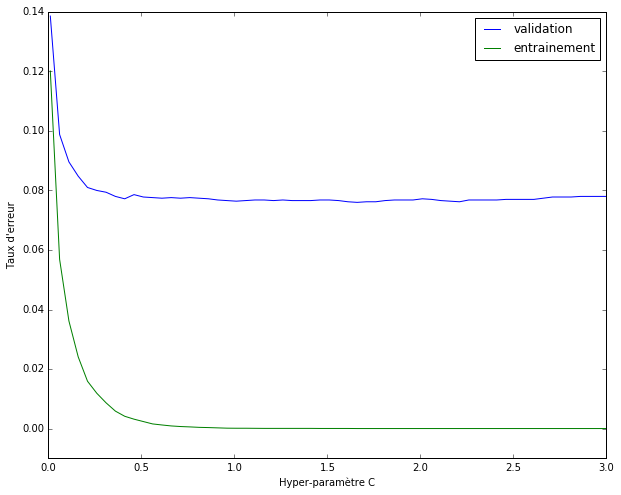

In [125]:
print 'Minimum validation rate:', np.min(Tri_V)
print 'Best value for C:', Cs[np.argmin(Tri_V)]

linearSVM = svm.LinearSVC(C=Cs[np.argmin(Tri_V)], loss=loss, penalty=penalty, tol=tol)
print "C=", Cs[np.argmin(Tri_V)]
b = eval_clf(linearSVM, data_tfidf[0])
print b

plt.figure(figsize=(10,8))
plt.plot(Cs,Tri_V,'b',label='validation')
plt.plot(Cs,Tri_T,'g',label='entrainement')

plt.legend()
plt.xlabel(u'Hyper-paramètre C')
plt.ylabel("Taux d'erreur")
plt.xlim(0, 3)
plt.ylim(-0.01,0.14)
plt.savefig('LinearSVC.pdf')
plt.show()

Normalized confusion matrix
[[ 0.92  0.08]
 [ 0.07  0.93]]


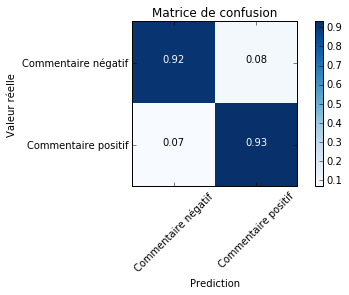

In [123]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(u'Valeur réelle')
    plt.xlabel('Prediction')

# Compute confusion matrix
cnf_matrix = confusion_matrix(doc_predictions[0], doc_predictions[1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[u'Commentaire négatif', u'Commentaire positif'],
                      title=u"Matrice de confusion")
plt.savefig('confusion.pdf', dpi=fig.dpi)
plt.show()



In [132]:
###Find the error on the test data
test_data = data_tfidf[0][4]
test_targets = data_tfidf[0][5]
train_data = data_tfidf[0][0]
train_targets = data_tfidf[0][1]

clf = svm.LinearSVC(C=1.66, loss='squared_hinge', penalty='l2', tol=1e-3)

time0 = time.time()

clf.fit(train_data, train_targets)  #Fit on train data

predictions_test = clf.predict(test_data)
error_test = 1 - (predictions_test == test_targets).mean()

time1 = time.time()

print "It took {} seconds".format(time1-time0)
print "Test error: ", error_test*100

It took 2.84070205688 seconds
Test error:  8.14
